# Vanila GAN on MNIST

In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

## Data preparation

In [2]:
# download & normalize data

compose = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((.5), (.5))])
data = datasets.MNIST(root = './dataset', train = True, 
                      transform = compose, download = True)

In [3]:
#Create data loader with data

data_loader = torch.utils.data.DataLoader(data, batch_size = 100, shuffle = True)
num_batches = len(data_loader) #600

In [4]:
device = "cuda"

## Design Network

### Discriminator

In [5]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 28 * 28
        n_out = 1
        
        self.layer1 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        return (x)

### Generator

In [6]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.layer1 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh() #to map value into (-1, 1) range
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        return (x)

In [7]:
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet().to(device)

## Functions & Utility

### Optimizer

In [8]:
d_optimizer = optim.Adam(discriminator.parameters(), lr = 2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr = 2e-4)

### Train function for discriminator

#### Loss function
Use Binary Cross Entropy loss

L = y * log(x) + (1 - y) * log(1 - x)

to change this to discriminator loss, we only have to put right label

In [9]:
loss = nn.BCELoss() # L = y * log(x) + (1 - y) * log(1 - x)

In [10]:
#label real and fake batch with ones and zeros
def ones_target(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def zeros_target(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    
    N = real_data.size(0)
    optimizer.zero_grad()
    
    #train on real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()
    
    #train on fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward() #gradient accumulated
    
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

### Train function for Generator

#### Loss function
As mentioned in the paper, rather than minimizing log(1 - D(G(z)), maximize log D(G(z)) to avoid gradient saturation problem


In [12]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    prediction = discriminator(fake_data)
    error = loss(prediction, ones_target(N))
    error.backward()
    optimizer.step()
    
    return error

### Aditional functions

In [13]:
## Add noise to inputs, decay over time
def noise(size):
    n = Variable(torch.randn(size, 100)).to(device)
    return n

In [14]:
def images_to_vectors(images):
    return images.view(images.size(0), 784).to(device)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 28, 28)

## Training

In [15]:
num_epochs = 10

# to plot graph
da_error = np.zeros(num_epochs)
ga_error = np.zeros(num_epochs)
d_real_accuracy = np.zeros(num_epochs)
d_fake_accuracy = np.zeros(num_epochs)

#to see visualy
num_test_samples = 16
test_noise = noise(num_test_samples)

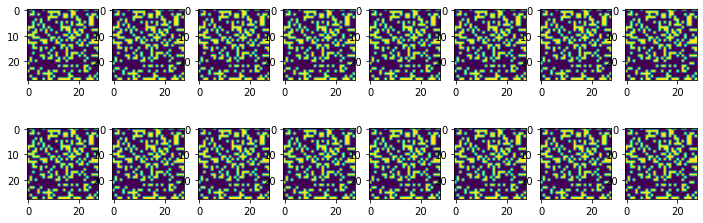

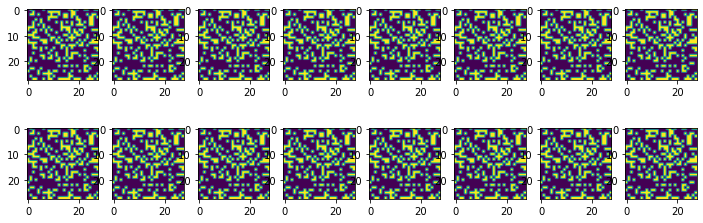

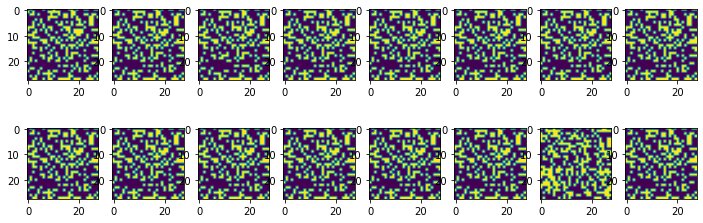

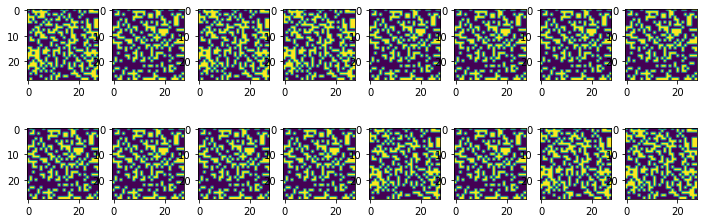

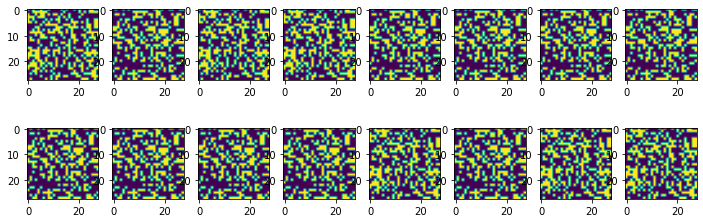

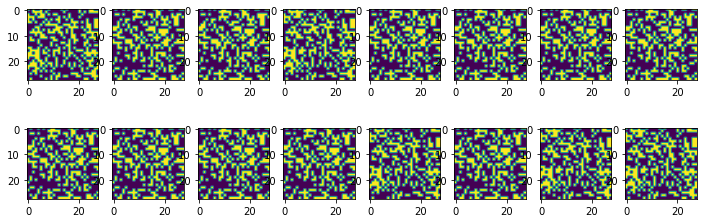

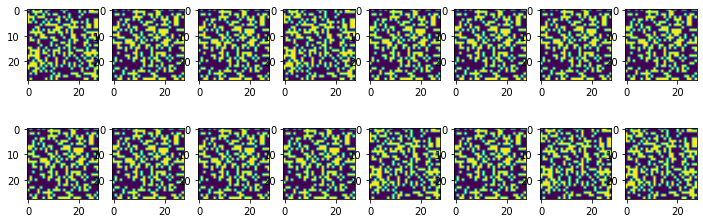

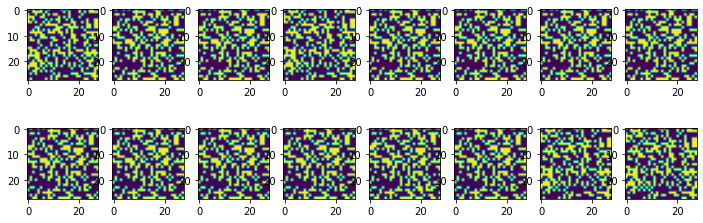

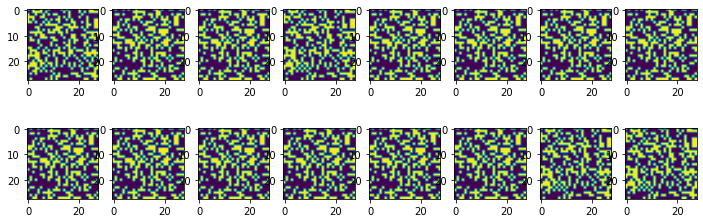

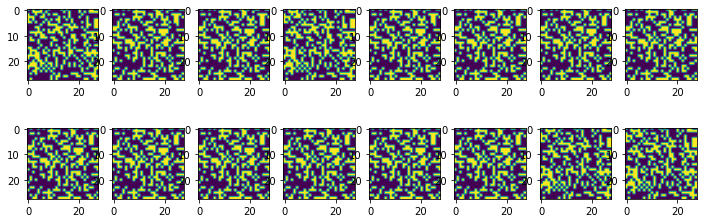

In [16]:
#we do not need actual label because this is not classification problem
for epoch in range(num_epochs):
    for n_batch, (batch, label) in enumerate(data_loader):
        N = batch.size(0)
        batch = batch.to(device)
        #Train Discriminator
        
        real_data = Variable(images_to_vectors(batch))
        #detach not to calculate the gradient of generator
        fake_data = generator(noise(N)).detach()
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
       
        da_error[epoch] += d_error
        d_real_accuracy[epoch] += (d_pred_real > 0.5).reshape(-1).mean(dtype = float)
        d_fake_accuracy[epoch] += (d_pred_fake < 0.5).reshape(-1).mean(dtype = float)
        
        #Train Generator
        
        fake_data = generator(noise(N))
        g_error = train_generator(g_optimizer, fake_data)
        ga_error[epoch] += g_error
        
    da_error[epoch] /= num_batches
    ga_error[epoch] /= num_batches
    d_real_accuracy[epoch] /= num_batches
    d_fake_accuracy[epoch] /= num_batches
    
    if(epoch % 1 == 0):
        print("Generated image on epoch ", i)
        test_images = vectors_to_images(generator(test_noise).to("cpu")).detach().numpy()
        fig=plt.figure(figsize=(12, 4))
        columns = 8
        rows = 2
        for i in range(1, 17):
            fig.add_subplot(rows, columns, i)
            plt.imshow(test_images[i - 1])
        plt.show()

### Loss, Accuracy over epoch

In [17]:
def plot_multiple_graph(arr1, arr2, label1, label2, title, ylabel):
    plt.figure(4, figsize=(10,6))
    plt.title(title)
    plt.plot(arr1, label=label1)
    plt.plot(arr2, label=label2)
    plt.xlabel('Iterations')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

#### Loss

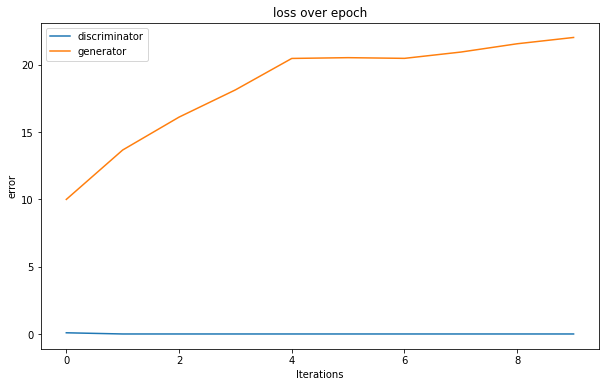

In [18]:
plot_multiple_graph(da_error, ga_error, "discriminator", "generator", "loss over epoch", "error")

### Accuracy

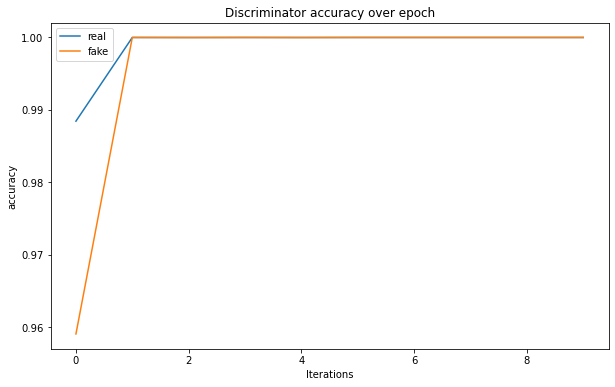

In [19]:
plot_multiple_graph(d_real_accuracy, d_fake_accuracy, "real", "fake", "Discriminator accuracy over epoch", "accuracy")

In [ ]:
plt.imgshow